# Models - GRU and LSTM - draft (JR_01)

In [1]:
import pandas as pd
import numpy as np
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from datetime import datetime
from keras.layers import Dense, GRU, Input, LSTM
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# loading dataset - CHANGE TO CORRECT LOADING THROUGH SCRIPTS!!!!
wkdir = '../data/raw/'

# df_errors = pd.read_csv(wkdir + 'PdM_errors.csv', parse_dates=['datetime'])
df_failures = pd.read_csv(wkdir + 'PdM_failures.csv', parse_dates=['datetime'])
df_machines = pd.read_csv(wkdir + 'PdM_machines.csv')
df_maint = pd.read_csv(wkdir + 'PdM_maint.csv', parse_dates=['datetime'])
df_telemetry = pd.read_csv(wkdir + 'PdM_telemetry.csv', parse_dates=['datetime'])

In [3]:
df_telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
# A total of 876100 rows (telemetry)

In [5]:
# Create dummies
# df_err = pd.get_dummies(df_errors, columns = ['errorID'], dtype=int, prefix='', prefix_sep='').groupby(['datetime','machineID']).sum().reset_index()
df_fail = pd.get_dummies(df_failures, columns = ['failure'], dtype=int, prefix='fail').groupby(['machineID','datetime']).sum().reset_index()
df_mnt = pd.get_dummies(df_maint, columns = ['comp'], dtype=int, prefix='maint').groupby(['machineID','datetime']).sum().reset_index()

In [6]:
# transform values to numbers
# df_failures['failure'] = df_failures['failure'].str.removeprefix('comp').astype(int)
df_machines['model'] = df_machines['model'].str.removeprefix('model').astype(int)
# df_machines['age'] = df_machines['age'].astype(np.float32)

In [7]:
# merging dataset
# merge all dfs into one.
# df_tele_err = pd.merge(df_telemetry, df_err, how='left', on=['datetime', 'machineID'])
df_tele_fail = pd.merge(df_telemetry, df_fail, how='left', on=['datetime', 'machineID'])
df_tele_fail_maint = pd.merge(df_tele_fail, df_mnt, how='left', on=['datetime', 'machineID'])
df_all = pd.merge(df_tele_fail_maint, df_machines, how='left', on="machineID")


In [8]:
print(df_all.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  fail_comp1  fail_comp2  fail_comp3  fail_comp4  maint_comp1  \
0  45.087686         NaN         NaN         NaN         NaN          NaN   
1  43.413973         NaN         NaN         NaN         NaN          NaN   
2  34.178847         NaN         NaN         NaN         NaN          NaN   
3  41.122144         NaN         NaN         NaN         NaN          NaN   
4  25.990511         NaN         NaN         NaN         NaN          NaN   

   maint_comp2  maint_comp3  maint_comp4  model  age  
0          NaN          NaN          NaN      3  

In [9]:
# replace NaN with 0
df_all.iloc[:,6:14] = df_all.iloc[:,6:14].fillna(0).astype(int)

In [10]:
# Flags for Failures and Maintenance
# df_all['error_flag'] = np.where(df_all[['error1', 'error2', 'error3', 'error4', 'error5']].sum(axis=1) == 0, 0, 1)
df_all['maint_flag'] = np.where(df_all[['maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4']].sum(axis=1) == 0, 0, 1)        #.astype(np.float32)
df_all['fail_flag'] = np.where(df_all[['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4']].sum(axis=1) == 0, 0, 1)     #.astype(np.float32)

In [11]:
# remove columns
df = df_all.drop(columns=['fail_comp1', 'fail_comp2', 'fail_comp3', 'fail_comp4', 'maint_comp1', 'maint_comp2', 'maint_comp3', 'maint_comp4'])
# print(df.head())

In [12]:
# Train set first=0, last=582599
# Validation set first=582600, last=728999
# Test set first=729000, last=875399

In [13]:
df = df.sort_values(by=['datetime', 'machineID']).reset_index().drop(columns='index')

In [14]:
print(df.head())

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 06:00:00          2  176.558913  424.624162   76.005332   
2 2015-01-01 06:00:00          3  185.482043  461.211137   87.453199   
3 2015-01-01 06:00:00          4  169.710847  463.646727   95.929877   
4 2015-01-01 06:00:00          5  165.082899  452.283576   84.591722   

   vibration  model  age  maint_flag  fail_flag  
0  45.087686      3   18           0          0  
1  43.767049      4    7           0          0  
2  28.216864      3    8           0          0  
3  38.400372      3    7           0          0  
4  40.298803      3    2           0          0  


In [15]:
# Train, Validation and Test sets
start_val = 582600      # index for first validation set row
start_test = 729000      # index for first test set row
end_test = 875400

train_df = df[:start_val]
val_df = df[start_val:start_test]
# full_train_df = df[:start_test]
test_df = df[start_test:end_test]

In [16]:
# Sort by MachineID and datetime to get the whole time-series for each machine
train_df = train_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')
val_df = val_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')
test_df = test_df.sort_values(by=['machineID', 'datetime']).reset_index().drop(columns='index')

In [17]:
print(train_df.head(3))
print(train_df.tail(3))
print(val_df.head(3))
print(val_df.tail(3))
print(test_df.head(3))

             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   

   vibration  model  age  maint_flag  fail_flag  
0  45.087686      3   18           0          0  
1  43.413973      3   18           0          0  
2  34.178847      3   18           0          0  
                  datetime  machineID        volt      rotate    pressure  \
582597 2015-08-31 21:00:00        100  180.232120  363.348361  104.129018   
582598 2015-08-31 22:00:00        100  161.443647  537.142083   88.031659   
582599 2015-08-31 23:00:00        100  174.334022  476.315237  108.612818   

        vibration  model  age  maint_flag  fail_flag  
582597  34.448304      4    5           0          0  
582598  42.626341      4    5           0          0  
582599  40.391854      4    5        

In [18]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(582600, 10)
(146400, 10)
(146400, 10)


### Sequencing

In [19]:
# Create sequences
def create_sequences(df, seq_length):
    df_np = df.to_numpy()
    x, y = [], []
    for i in range(len(df_np) - seq_length):
        row = [r for r in df_np[i:i+seq_length, 2:6]]
        label = [df_np[i+seq_length][2], df_np[i+seq_length][3], df_np[i+seq_length][4], df_np[i+seq_length][5]]
        x.append(row)
        y.append(label)
    return np.asarray(x), np.asarray(y)

In [20]:
# Sequence length 
seq_length = 4
X_train_seq, y_train_seq = create_sequences(train_df, seq_length)
X_val_seq, y_val_seq = create_sequences(val_df, seq_length)
X_test_seq, y_test_seq = create_sequences(test_df, seq_length)
print(X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape)

(582596, 4, 4) (582596, 4) (146396, 4, 4) (146396, 4) (146396, 4, 4) (146396, 4)


In [21]:
X_train_seq = tf.convert_to_tensor(X_train_seq, dtype=tf.float32)
X_val_seq = tf.convert_to_tensor(X_val_seq, dtype=tf.float32)

In [45]:
# Save test sequences and labels for later use in streamlit app
np.save('../data/test_seq_tele', X_test_seq)
np.save('../data/test_label_tele', y_test_seq)

# GRU model

In [74]:
# GRU model
def build_GRU(X_train):
    time_steps = X_train.shape[1]
    feat = X_train.shape[2]
    model = Sequential()
    model.add(Input(shape=(time_steps, feat)))
    model.add((GRU(units=64, activation='relu')))
    model.add(Dense(32, activation='relu'))  
    model.add(Dense(4))
    
    return model

In [75]:
# Build GRU
model_GRU = build_GRU(X_train_seq)  
# model_GRU.summary()

In [76]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cp = ModelCheckpoint('../models/Trained models/GRU_model.keras', monitor='val_loss', save_best_only=True)

In [77]:
# Compile and fit GRU
model_GRU.compile(optimizer=Adam(learning_rate=0.0002), loss='huber', metrics=[MeanSquaredError()])

In [78]:
history_GRU = model_GRU.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), verbose=1, epochs=50, callbacks=[early_stopping, cp]) 

Epoch 1/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 23.3253 - mean_squared_error: 2638.5107 - val_loss: 16.4499 - val_mean_squared_error: 790.5020
Epoch 2/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 16.4108 - mean_squared_error: 795.0204 - val_loss: 16.3616 - val_mean_squared_error: 784.0233
Epoch 3/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 16.3396 - mean_squared_error: 788.9980 - val_loss: 16.5832 - val_mean_squared_error: 796.5190
Epoch 4/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 16.2963 - mean_squared_error: 783.6414 - val_loss: 16.1181 - val_mean_squared_error: 767.0445
Epoch 5/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - loss: 16.1666 - mean_squared_error: 773.1389 - val_loss: 16.0139 - val_mean_squared_error: 762.5536
Epoch 6/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - loss: 16.1168 - mean_squared_error: 769.5903 - val_loss: 15.9865 - val_mean_squared_error: 753.4503
Epoch 7/50
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 4

In [79]:
# Save GRU model
# model_GRU.save('../models/Trained models/model_GRU.keras')

In [80]:
y_pred_val = model_GRU.predict(X_val_seq)   

4575/4575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [81]:
# inverse scaling transform

# 

In [82]:
# Plot predictions and actual values
def plot_preds(preds, actuals, start, end):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
    axs[0, 0].plot(actuals[start:end, 0], color='green', label='Actual')
    axs[0, 0].plot(preds[start:end, 0], color='red', label='Predicted')
    axs[0, 1].plot(actuals[start:end, 1], color='green', label='Actual')
    axs[0, 1].plot(preds[start:end, 1], color='red', label='Predicted')
    axs[1, 0].plot(actuals[start:end, 2], color='green', label='Actual')
    axs[1, 0].plot(preds[start:end, 2], color='red', label='Predicted')
    axs[1, 1].plot(actuals[start:end, 3], color='green', label='Actual')
    axs[1, 1].plot(preds[start:end, 3], color='red', label='Predicted')
    axs[0, 0].set_title('Volt')
    axs[0, 1].set_title('Rotate')
    axs[1, 0].set_title('Pressure')
    axs[1, 1].set_title('Vibration')
    plt.legend()

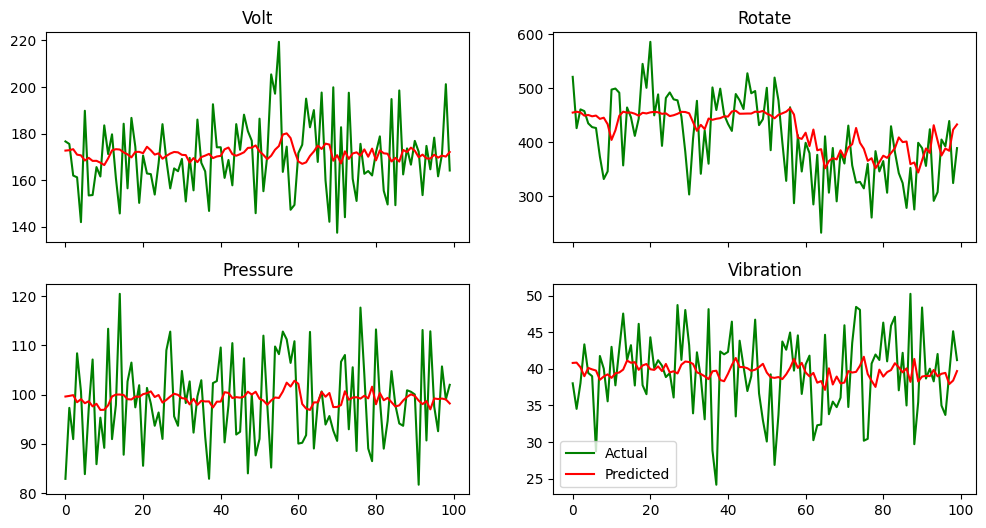

In [83]:
plot_preds(y_pred_val, y_val_seq, 100, 200)

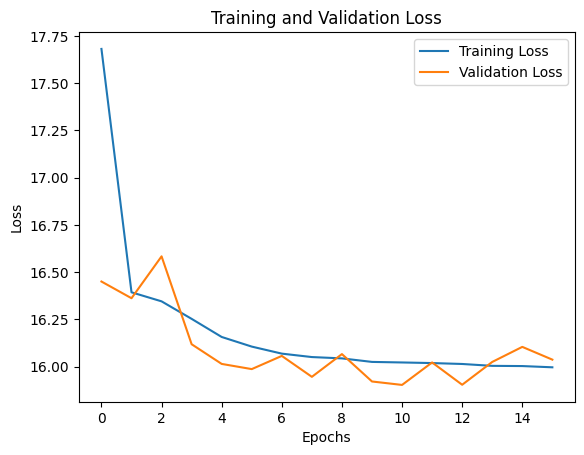

In [84]:
plt.plot(history_GRU.history['loss'], label='Training Loss')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [1135]:
##########################

# LSTM

In [183]:
# LSTM model
def build_LSTM(X_train):
    shape_1 = X_train.shape[1]
    shape_2 = X_train.shape[2]
    model = Sequential()
    model.add(Input(shape=(shape_1, shape_2)))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4))
    
    return model

In [184]:
# Build LSTM
model_LSTM = build_LSTM(X_train_seq)
# model_LSTM.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,156 (207.64 KB)

 Trainable params: 53,156 (207.64 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
# Compile and fit LSTM
model_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss='huber', metrics=[MeanSquaredError()])

In [186]:
history_LSTM = model_LSTM.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), verbose=1, epochs=3)

Epoch 1/3


18207/18207 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - loss: 19.0346 - mean_squared_error: 1503.8301 - val_loss: 16.3605 - val_mean_squared_error: 781.1875
Epoch 2/3
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - loss: 16.4048 - mean_squared_error: 790.8481 - val_loss: 16.8032 - val_mean_squared_error: 838.0816
Epoch 3/3
18207/18207 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step - loss: 16.1557 - mean_squared_error: 771.7475 - val_loss: 15.9244 - val_mean_squared_error: 749.0342


In [187]:
# Save LSTM model
model_LSTM.save('../models/model_saves/model_LSTM.keras')

In [188]:
y_pred_val_LSTM = model_LSTM.predict(X_val_seq)

4575/4575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [189]:
# print(y_pred_val_LSTM)

In [190]:
# print(y_val_seq)

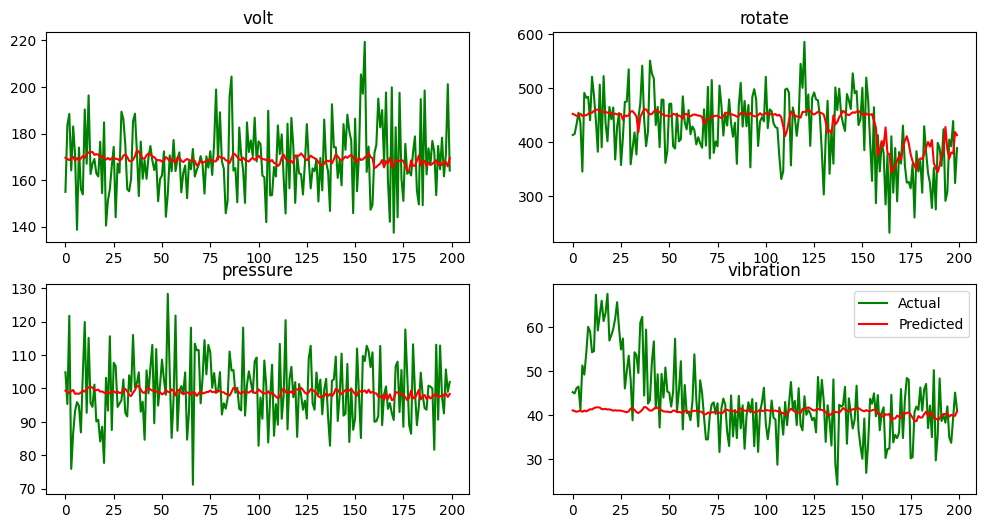

In [191]:
# Plot predictions and actual values
plot_preds(y_pred_val_LSTM, y_val_seq, 100, 200)

In [ ]:
plt.plot(history_LSTM.history['loss'], label='Training Loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()